In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import sys
import pandas as pd
sys.path.append('../spock/')
from modelfitting import ROC_curve
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics
from xgboost.sklearn import XGBClassifier

try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

# Resonant

N-body AUC = 0.9913 Thresh = 0.005 TPR = 1.000 FPR = 0.139 Thresh = 0.943 TPR = 1.000 FPR = 0.017
SPOCK AUC = 0.9526 Thresh = 0.335 TPR = 0.850 FPR = 0.100 Thresh = 0.236 TPR = 0.900 FPR = 0.136
MEGNO AUC = 0.8647 Thresh = 0.515 TPR = 0.499 FPR = 0.104 Thresh = 0.301 TPR = 0.900 FPR = 0.280
AMD AUC = 0.7259 Thresh = 0.418 TPR = 0.358 FPR = 0.101 Thresh = 0.226 TPR = 0.900 FPR = 0.716
Hill AUC = 0.7248 Thresh = 0.416 TPR = 0.298 FPR = 0.101 Thresh = 0.208 TPR = 0.900 FPR = 0.625


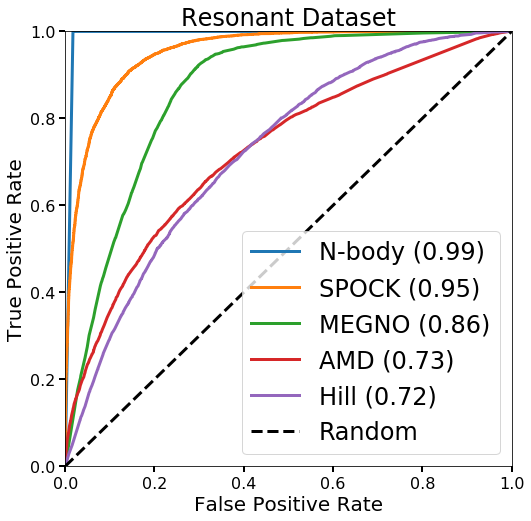

In [2]:
models = {'N-body':'nbody', 'SPOCK':'featureclassifier', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
featuresdic = {'N-body':['shadow_instability_time'], 'SPOCK':None, 'MEGNO':['MEGNO'], 'AMD':['AMDfracnear', 'AMDfracfar'], 'Hill':['betanear', 'betafar']}
testing_dataset = 'resonant'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

FPRthresh = 0.1
TPRthresh = 0.9

for name, filename in models.items():
    model = XGBClassifier()
    model.load_model('../spock/models/'+filename+'.json')
    if name == 'SPOCK':
        testingdatafolder = '../training_data/resonant/featuresNorbits10000.0Nout80trio/'  
    elif name == 'N-body':
        testingdatafolder = '../training_data/resonant/shadowtimes/'
    else:
        testingdatafolder = '../training_data/resonant/additional_featuresNorbits10000.0Nout80trio/'
        
    dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
    labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
    
    Nrows = int(0.8*dataset.shape[0])
    testX = dataset.iloc[Nrows:, :]
    testy = labels['Stable'].iloc[Nrows:]
    
    features = featuresdic[name]
    if features is not None:
        testX = testX[features]
    
    preds = model.predict_proba(testX)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(testy, preds)
    roc_auc = metrics.roc_auc_score(testy, preds)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    tprthreshindex = np.where(tpr > TPRthresh)[0][0]
    print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]), 
         "Thresh = {0:.3f}".format(ROCthresholds[tprthreshindex]),  "TPR = {0:.3f}".format(tpr[tprthreshindex]), "FPR = {0:.3f}".format(fpr[tprthreshindex]))
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))
    
ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.legend(fontsize=24)
ax.set_title('Resonant Dataset')
fig.savefig('resperformance.pdf', bbox_inches='tight')

In [3]:
df = pd.read_csv('../training_data/resonant/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col = 0)
labels = pd.read_csv('../training_data/resonant/additional_featuresNorbits10000.0Nout80trio/labels.csv', index_col=0)
# Take only the last 20% that we use as a holdout set
Nrows = int(0.8*df.shape[0])
df = df.iloc[Nrows:, :]
labels = labels.iloc[Nrows:]

In [4]:
chaotic = labels[df['MEGNO'] > 2.5]
chaotic['Stable'].sum()/chaotic.shape[0]

0.0225832822399346

In [5]:
regular = labels[df['MEGNO'] < 2.5]
(regular['Stable']==False).sum()/regular.shape[0]

0.5504799146818343

In [6]:
AMDstable = labels[(df['AMDfracnear'] < 1) & (df['AMDfracfar'] < 1)]

In [7]:
AMDstable['Stable'].sum()/AMDstable.shape[0]

0.48189675309507124

In [8]:
AMDstable.shape[0]/labels.shape[0]

0.18851556651547843